In [13]:
%ls

random_forest_7day_churn.ipynb  test_7d_encoded.csv  train_7d_encoded.csv


In [14]:
%cd ..

/workspace/asurion_f22_wut/fe_data_v2


In [15]:
%cd ..

/workspace/asurion_f22_wut


In [16]:
%ls

data/         fe_data_v2/                  random_forest_testing.ipynb
fe_data/      fe_data_v3/
fe_data_new/  random_forest_pipline.ipynb


In [17]:
%cd fe_data_v3

/workspace/asurion_f22_wut/fe_data_v3


In [18]:
%ls

30_day_churn_data/  90_day_churn_data/  total_sale_data/
7_day_churn_data/   sale_data/          transcript_data/


In [19]:
%cd 7_day_churn_data

/workspace/asurion_f22_wut/fe_data_v3/7_day_churn_data


In [20]:
%ls

test_7d_encoded.csv  train_7d_encoded.csv


In [21]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [22]:
train_df = pd.read_csv('train_7d_encoded.csv', index_col='id')

In [23]:
test_df = pd.read_csv('test_7d_encoded.csv', index_col='id')

In [26]:
dcols = ['quality_sale', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'hh_income_code', 'month']

In [28]:
test_df.drop(columns = dcols, inplace = True)
test_df = test_df[(test_df['zipcode_accepted_prop'].isnull()==False)& (test_df['zipcode_rejected_offers'].isnull()==False)& 
            (test_df['zipcode_accepted_offers'].isnull()==False)&(test_df['zipcode_total_offers'].isnull()==False)]

In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18316 entries, 317874eac956ff7012276c7afd08c2730a125245715fd635a866b148 to bed85bfdbd02f078a984e37353307414d42baf40eb7a1b34569c1bd6
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   seven_day_churn             18316 non-null  float64
 1   lines                       18316 non-null  int64  
 2   previous_tech_support_call  18316 non-null  int64  
 3   account_tenure              18316 non-null  int64  
 4   past_yr_claim_count         18316 non-null  int64  
 5   num_decline                 18316 non-null  int64  
 6   exp                         18316 non-null  int64  
 7   product_type                18316 non-null  object 
 8   pmake                       18316 non-null  object 
 9   claritas_hh_count           18316 non-null  int64  
 10  technodoption_class         18316 non-null  object 
 11  hh_income                   18316 non-null  

In [30]:
np.unique(test_df['seven_day_churn'], return_counts = True)

(array([0., 1.]), array([17057,  1259]))

In [31]:
train_df.drop(columns = dcols, inplace = True)
train_df = train_df[(train_df['zipcode_accepted_prop'].isnull()==False)& (train_df['zipcode_rejected_offers'].isnull()==False)& 
            (train_df['zipcode_accepted_offers'].isnull()==False)&(train_df['zipcode_total_offers'].isnull()==False)]

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84339 entries, 68943556bf63277816d843ffb129e23ffe60bc5b982603ec9519659a to 4644f9d78e15ade04ac732eedd8944c2e918e81b288f0cadd481abbd
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   seven_day_churn             84339 non-null  float64
 1   lines                       84339 non-null  int64  
 2   previous_tech_support_call  84339 non-null  int64  
 3   account_tenure              84339 non-null  int64  
 4   past_yr_claim_count         84339 non-null  int64  
 5   num_decline                 84339 non-null  int64  
 6   exp                         84339 non-null  int64  
 7   product_type                84339 non-null  object 
 8   pmake                       84339 non-null  object 
 9   claritas_hh_count           84339 non-null  int64  
 10  technodoption_class         84339 non-null  object 
 11  hh_income                   84339 non-null  

In [33]:
np.unique(train_df['seven_day_churn'], return_counts = True)

(array([0., 1.]), array([79249,  5090]))

In [34]:
num_list = ['lines', 'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count', 'num_decline', 
            'claritas_hh_count', 'median_income', 'total_population', 'perc_female', 'perc_under18',
            'perc_over65', 'perc_white', 'perc_black', 'population_density',
            'zipcode_accepted_prop', 'zipcode_rejected_offers', 'zipcode_accepted_offers', 'zipcode_total_offers']
cat_list = ['exp', 'product_type', 'pmake', 'technodoption_class', 'hh_income', 'age_class', 'hh_education', 
            'hh_composition', 'hh_tenure', 'urbanicity', 'day_of_week', 'time_of_day']
len(num_list+cat_list)

30

In [35]:
class_column = 'seven_day_churn'
random_seed = 20
data = train_df.copy()
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=class_column), data[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=data[class_column]
                                                   )

In [36]:
onehot = OneHotEncoder(handle_unknown='ignore')
minmax = MinMaxScaler()
ct = ColumnTransformer([("onehot", onehot, cat_list),("minmax", minmax, num_list)])
pipeline = Pipeline([("col", ct), ("mdl", RandomForestClassifier(class_weight='balanced'))])

In [37]:
tuning_grid = {'mdl__n_estimators' : [10,20,30,40],
               'mdl__max_depth' : [2,3,4,5],
               'mdl__min_samples_split': [5,8,11,13],
               'mdl__min_samples_leaf': [1,3,5,7]
               
                }
grid_search = GridSearchCV(pipeline, param_grid = tuning_grid, cv = 5, return_train_score=True,  verbose = 1, 
                      n_jobs = -1, scoring = 'recall')
start=time.time()
grid_search.fit(X_train, y_train)
print('best score for grid search:', grid_search.best_score_)

display(grid_search.best_params_)
print('Timer:', time.time()-start, 'seconds')
random_forest_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
best score for grid search: 0.52973966088669


{'mdl__max_depth': 2,
 'mdl__min_samples_leaf': 7,
 'mdl__min_samples_split': 8,
 'mdl__n_estimators': 10}

Timer: 156.43079328536987 seconds


In [38]:
preds = random_forest_classifier.predict_proba(X_test)


In [39]:
print(preds)


[[0.51356788 0.48643212]
 [0.52194161 0.47805839]
 [0.52159454 0.47840546]
 ...
 [0.49974406 0.50025594]
 [0.50404698 0.49595302]
 [0.51115696 0.48884304]]


In [40]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
#print(np.unique(predictions, return_counts = True))
#print(np.unique(y_pred, return_counts = True))
#print(y_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("random_forest",'\n',
      "recall:",recall_score(y_test, predictions),'\n',
      "precision:",precision_score(y_test, predictions),'\n',
      "f1score:",f1_score(y_test, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest 
 recall: 0.48625294579732914 
 precision: 0.07690396322524537 
 f1score: 0.1328041192877065 
 tn:12382, fp:7430, fn:654, tp:619 



In [41]:
joblib.dump(random_forest_classifier, 'rf_seven_day_churn.pkl')

['rf_seven_day_churn.pkl']

In [42]:
x = test_df.drop(columns=class_column)
y = test_df[class_column]

In [43]:
rf_model = joblib.load('rf_seven_day_churn.pkl')

In [44]:
preds = rf_model.predict_proba(x)


In [45]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("random_forest_test_july",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest_test_july 
 recall: 0.43208895949166004 
 precision: 0.0757238307349666 
 f1score: 0.12886414781475777 
 tn:10417, fp:6640, fn:715, tp:544 



In [46]:
threshold=0.55
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("random_forest_test_july",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest_test_july 
 recall: 0.023034154090548053 
 precision: 0.07754010695187166 
 f1score: 0.03551745254133496 
 tn:16712, fp:345, fn:1230, tp:29 



In [47]:
threshold=0.60
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("random_forest_test_july",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest_test_july 
 recall: 0.0 
 precision: 0.0 
 f1score: 0.0 
 tn:17057, fp:0, fn:1259, tp:0 



In [48]:
threshold=0.45
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("random_forest_test_july",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest_test_july 
 recall: 0.9960285941223193 
 precision: 0.06861833105335158 
 f1score: 0.1283915224736357 
 tn:36, fp:17021, fn:5, tp:1254 



In [49]:
threshold=0.40
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("random_forest_test_july",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest_test_july 
 recall: 0.9976171564733916 
 precision: 0.06867515993219968 
 f1score: 0.12850419480253733 
 tn:24, fp:17033, fn:3, tp:1256 



In [50]:
vip = random_forest_classifier.steps[1][1].feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':list(random_forest_classifier.steps[0][1].transformers_[0][1].get_feature_names())+num_list, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(10)

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
zipcode_rejected_offers,0.22,0.22,1.00
population_density,0.11,0.11,1.00
x10_Sunday,0.08,0.08,1.00
median_income,0.08,0.08,1.00
zipcode_accepted_offers,0.08,0.08,1.00
x1_MD,0.07,0.07,1.00
perc_white,0.06,0.06,1.00
past_yr_claim_count,0.06,0.06,1.00
x1_SD,0.05,0.05,1.00


In [51]:
feature_importances_info.to_csv('feature_importances_seven_day_churn_rf.csv')

In [52]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


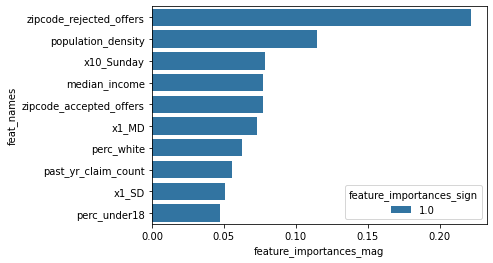

In [53]:

import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);

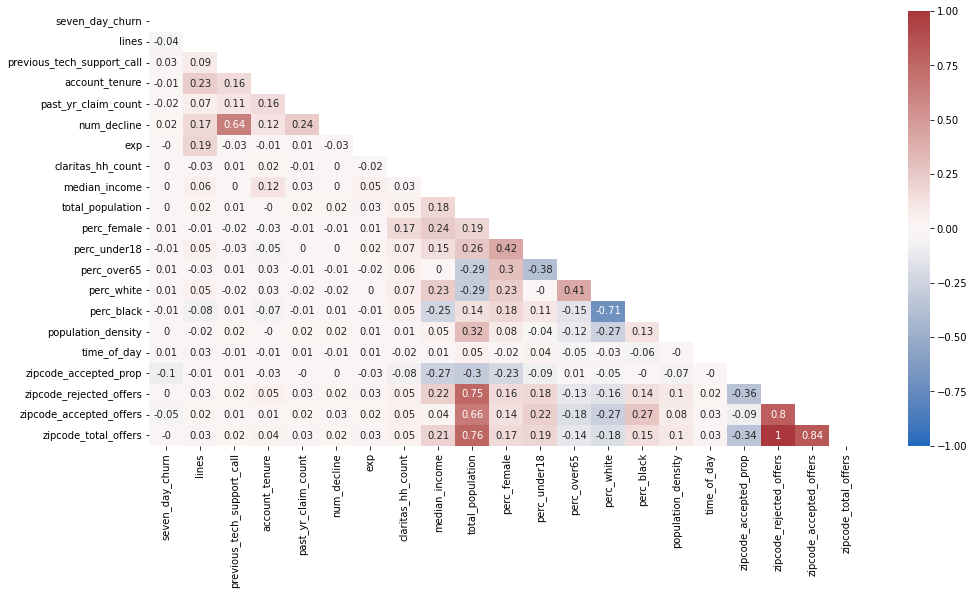

In [54]:
plt.figure(figsize = (16,8))
matrix = train_df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()